# Fisher matrix 

Compute Fisher matrix with ARF and ADF

In [1]:
import numpy as np
import scipy
import os
import matplotlib.pyplot as plt
import sys
import copy
import itertools
from scipy.linalg import block_diag

import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
from camb.fisher.cachers import cacher_pk
from camb.fisher.utils import enumerate_progress

from getdist import plots
from getdist.gaussian_mixtures import GaussianND

from os.path import join as opj

print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))


Using CAMB 1.3.6 installed at /Users/louis/Code/CAMBfork/camb


In [2]:
from camb import fisher

In [3]:
fiducial_ffp10_plancklens = {
#     'Alens':1,
    'As': 2.119631e-09,
    'ns': 0.9636852,
    'H0': 67.01904,
#     'theta_MC_100':0.010407224216796775 *100,
    'ombh2': 0.02216571,
    'omch2': 0.1202944,
    'tau':0.06018107,
    'mnu':0.1,
    'omk':0,
    'w':-1,
#     'wa':0
}

fiducials = fiducial_ffp10_plancklens

In [4]:
# Params to derivate 

# params = ['As', 'ns', 'H0', 'ombh2', 'omch2', 'mnu']
params = ['As', 'ns', 'H0', 'ombh2', 'omch2', 'mnu']
# params = ['omch2', 'mnu']
# params = ['As']

npar= len(params)

In [5]:
# Cls to use in the Fisher matrix 

# cl_keys = ['W1xW1', 'W1xW2', 'W2xW2']

In [6]:
latex = {
    'logA':r'\log(10^{10} A_\mathrm{s})',
    'As':r'A_\mathrm{s})',
    'ns': r'n_\mathrm{s}', 
    'theta_MC_100':r'100\theta_\mathrm{MC}', 
    'ombh2':r'\Omega_\mathrm{b} h^2', 
    'omch2':r'\Omega_\mathrm{c} h^2', 
    'tau':r'\tau_\mathrm{reio}', 
    'mnu':r'\sum m_\nu', 
    'omk':r'\Omega_k', 
    'w':r'w_0',
    'wa':r'w_\mathrm{a}',
    'H0':r'H_0'
}

labels = [latex[par] for par in params]

mean = [fiducials[par] for par in list(params)]

# Get the gaussian covariance matrix

In [7]:
ngal_tot = 30 * 3600*(180/np.pi)**2
sig_eps = 0.3
ng_i = ngal_tot/10

In [8]:
nzbin = 1

# zmin = 0.1
# zmax= 2
sigz = 0.01
zmean = 1
zmin = zmean - nzbin/2*sigz
zmax = zmean + nzbin/2*sigz


zobs = np.linspace(zmin, zmax, nzbin)
sgzar = np.ones_like(zobs)*sigz



lmin = 10
lmax = 2000


biasP=1.66 
biasR=3.8

In [9]:
tmp_dir ='./tmp'


def get_libdir(nzbin, zmin, zmax, sigz, lmin, lmax, biasP, biasR): 
    return opj(tmp_dir, f"nzbin{nzbin}_zmin{zmin}_zmax{zmax}_sigz{sigz}_lmin{lmin}_lmax{lmax}_biasP{biasP}_biasR{biasR}")

In [10]:
libdir = get_libdir(nzbin, zmin, zmax, sigz, lmin, lmax, biasP, biasR)

cacher = cacher_pk(libdir)

In [11]:
# Fiducial Cls 

fn_cls_fid = 'cls_fid'
if not cacher.is_cached(fn_cls_fid):

    pars = camb.CAMBparams()

    pars.set_cosmology(H0=fiducials['H0'], ombh2=fiducials['ombh2'], omch2=fiducials['omch2'], mnu=fiducials['mnu'], omk=fiducials['omk'], tau=fiducials['tau'])

    pars.InitPower.set_params(As=fiducials['As'], ns=fiducials['ns'], r=0)


    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    #set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = False
    pars.Want_CMB_lensing = False

    #NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both



    # this dictionary considers both ADF (source_type="counts") and ARF (source_type="arf") for the same shell
    # pars.SourceWindows=[
    #     [[GaussianSourceWindow(redshift=z,source_type='counts',bias=biasP,sigma=sgz,dlog10Ndm=0.) for z in zobs] for sgz in sgzar],
    #     [[GaussianSourceWindow(redshift=z,source_type='arf',bias=biasP,sigma=sgz,dlog10Ndm=0.) for z in zobs] for sgz in sgzar]
    # ]


    pars.SourceWindows = [GaussianSourceWindow(redshift=zobs[i], source_type='counts', bias=biasP, sigma=sgzar[i], dlog10Ndm=0.) for i in range(nzbin)] + \
    [GaussianSourceWindow(redshift=zobs[i], source_type='arf', bias=biasP, sigma=sgzar[i], dlog10Ndm=0.) for i in range(nzbin)]

    results = camb.get_results(pars)

    cls_fid = results.get_source_cls_dict(raw_cl=True)
    cacher.cache(fn_cls_fid, cls_fid)

cls_fid = cacher.load(fn_cls_fid)

 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999851008     


In [12]:
# cls_fid.keys()

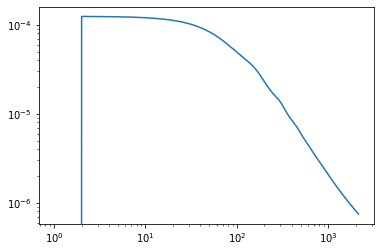

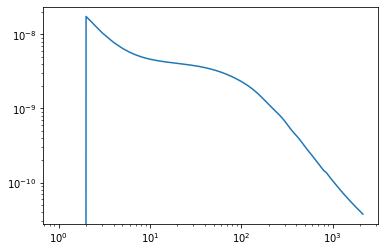

In [13]:
for i in range(nzbin):
    plt.loglog(cls_fid[f"W{i+1}xW{i+1}"])

plt.figure()
for i in range(nzbin):
    plt.loglog(cls_fid[f"W{i+1+nzbin}xW{i+1+nzbin}"])

In [14]:
# num_cls_keys = (2*nzbin)*(2*nzbin)
cl_keys = []
# for j in range(2*nzbin):
#     for i in range(2*nzbin-j):
for i, j in itertools.combinations_with_replacement(np.arange(2*nzbin), 2):
    cl_keys.append(f'W{i+1}xW{j+1}')

num_cl_keys = len(cl_keys)


cl_adf_keys = []
for i, j in itertools.combinations_with_replacement(np.arange(nzbin), 2):
    cl_adf_keys.append(f'W{i+1}xW{j+1}')
    
    
cl_arf_keys = []
for i, j in itertools.combinations_with_replacement(np.arange(nzbin), 2):
    cl_arf_keys.append(f'W{i+1+nzbin}xW{j+1+nzbin}')

In [15]:
# max_dist_bin = 0
max_dist_bin = nzbin

# num_cls_keys = (2*nzbin)*(2*nzbin)
cl_keys = []
# for j in range(2*nzbin):
#     for i in range(2*nzbin-j):
for i, j in itertools.combinations_with_replacement(np.arange(2*nzbin), 2):
    if np.abs(i-j) <= max_dist_bin:
        cl_keys.append(f'W{i+1}xW{j+1}')
    elif j>=nzbin and np.abs(i-(j-nzbin)) <= max_dist_bin:
#         print(i, j)
        cl_keys.append(f'W{i+1}xW{j+1}')


# for i in range(nzbin):
#     for j in range(nzbin-i-max_dist_bin):
#         cl_keys.append(f'W{i+1}xW{j+1}')


num_cl_keys = len(cl_keys)


cl_adf_keys = []
for i, j in itertools.combinations_with_replacement(np.arange(nzbin), 2):
    if np.abs(i-j) <= max_dist_bin:
        cl_adf_keys.append(f'W{i+1}xW{j+1}')
    
    
cl_arf_keys = []
for i, j in itertools.combinations_with_replacement(np.arange(nzbin), 2):
    if np.abs(i-j) <= max_dist_bin:
        cl_arf_keys.append(f'W{i+1+nzbin}xW{j+1+nzbin}')

In [16]:
cl_keys

['W1xW1', 'W1xW2', 'W2xW2']

In [17]:
len(cl_keys)

3

In [18]:
# cl_adf_keys

In [19]:
ells = np.arange(lmin, lmax) 
dell = np.ones_like(ells)

In [20]:
# ncl = len(cl_keys)

# fsky = 0.363609919  # Euclid fsky 


# cov_tot = []
# invcov_l = []
# for il, l in enumerate(ells):
# #     print(il, l)
#     cl_dict_l = {}
#     nl_dict = {}
# #     for idx, (i, j) in enumerate(indices_wl):
# #         spectrum = spectrum = 'W{}xW{}'.format(i+11, j+11)
    
#     # To do : Add noise 
#     for key in cl_keys:
#         cl_dict_l[key] = cls_fid[key][l]
        
#         nl_dict[key] = 0
#         if (key[:2] == key[-2:]):
#             nl_dict[key] = sig_eps**2/ng_i
            
            
# #     cl_keys = list(cl_dict_l.keys())

# #     ncl = len(cl_keys)

#     cov_l = np.zeros([ncl, ncl])

#     # Get symetric Cls for permutations
#     for key in cl_keys:
#         probeA, probeB = key.split('x')
#         cl_dict_l['x'.join([probeB, probeA])] = cl_dict_l[key]
#         nl_dict['x'.join([probeB, probeA])] = nl_dict[key]

#     for (idx1, key1), (idx2, key2) in itertools.combinations_with_replacement(enumerate(cl_keys), 2):
#         # print(key1, key2)
#         probeA, probeB = key1.split('x')
#         probeC, probeD = key2.split('x')
# #         if il == 0:
# #             print(probeA, probeB, probeC, probeD)
#         cov_l[idx1, idx2] = 1. / (fsky * (2. * l + 1.) * dell[il]) \
#             * (
#                 (cl_dict_l['x'.join([probeA, probeC])] + nl_dict['x'.join([probeA, probeC])]) *
#                 (cl_dict_l['x'.join([probeB, probeD])] + nl_dict['x'.join([probeB, probeD])]) +
#                 (cl_dict_l['x'.join([probeA, probeD])] + nl_dict['x'.join([probeA, probeD])]) *
#                 (cl_dict_l['x'.join([probeB, probeC])] + nl_dict['x'.join([probeB, probeC])])
#         )

#     # Get the symmetric matrix
#     cov_l = cov_l + cov_l.T - np.diag(cov_l.diagonal())
#     cov_tot.append(cov_l)
#     invcov_l.append(np.linalg.inv(cov_l))
    
# # covmat = block_diag(*cov_tot)

# # # np.save('covmat_euclid_wl', np.array(cov_tot))

In [21]:
def get_cov(cls_fid, cl_keys, fsky = 0.363609919):
    cov_tot = []
    invcov_l = []
    for il, l in enumerate_progress(ells):
#         print(l)
        cl_dict_l = {}
        nl_dict = {}

        #TODO : Add noise 
        for key in cls_fid.keys():
            cl_dict_l[key] = cls_fid[key][l]
            
            nl_dict[key] = 0
            if (key[:2] == key[-2:]):
                nl_dict[key] = sig_eps**2/ng_i
        ncl = len(cl_keys)
        cov_l = np.zeros([ncl, ncl])

        # Get symetric Cls for permutations
        for key in cl_keys:
            probeA, probeB = key.split('x')
            cl_dict_l['x'.join([probeB, probeA])] = cl_dict_l[key]
            nl_dict['x'.join([probeB, probeA])] = nl_dict[key]

        for (idx1, key1), (idx2, key2) in itertools.combinations_with_replacement(enumerate(cl_keys), 2):
            # print(key1, key2)
            probeA, probeB = key1.split('x')
            probeC, probeD = key2.split('x')
    #         if il == 0:
    #             print(probeA, probeB, probeC, probeD)
            cov_l[idx1, idx2] = 1. / (fsky * (2. * l + 1.) * dell[il]) \
                * (
                    (cl_dict_l['x'.join([probeA, probeC])] + nl_dict['x'.join([probeA, probeC])]) *
                    (cl_dict_l['x'.join([probeB, probeD])] + nl_dict['x'.join([probeB, probeD])]) +
                    (cl_dict_l['x'.join([probeA, probeD])] + nl_dict['x'.join([probeA, probeD])]) *
                    (cl_dict_l['x'.join([probeB, probeC])] + nl_dict['x'.join([probeB, probeC])])
            )

        # Get the symmetric matrix
        cov_l = cov_l + cov_l.T - np.diag(cov_l.diagonal())
        cov_tot.append(cov_l)
        invcov_l.append(np.linalg.inv(cov_l))
    return cov_tot, invcov_l

In [22]:
cov = {}
invcov = {}

for p in ['tot', 'adf', 'arf']:
    fn_cov = f'cov_{p}_maxdistbin{max_dist_bin}'
    fn_invcov = f'invcov_{p}_maxdistbin{max_dist_bin}'
    if p == 'tot':
        ck = cl_keys
    elif p == 'adf':
        ck = cl_adf_keys
    elif p == 'arf':
        ck = cl_arf_keys
    if np.any([not cacher.is_cached(fn) for fn in [fn_cov, fn_invcov]]):
        _cov, _invcov = get_cov(cls_fid, ck)
        cacher.cache(fn_cov, _cov)
        cacher.cache(fn_invcov, _invcov)
    cov[p] = cacher.load(fn_cov)
    invcov[p] = cacher.load(fn_invcov)           


 [00:00:00]  ---------> 99%
 [00:00:00]  ---------> 99%
 [00:00:00]  ---------> 99%


In [23]:
# fn_cov_adf = f'cov_adf_maxdistbin{max_dist_bin}'
# fn_invcov_adf = f'cov_adf_maxdistbin{max_dist_bin}'

# if np.any([not cacher.is_cached(fn) for fn in [fn_cov_adf, fn_invcov_adf]]):
#     cov, invcov = get_cov(cls_fid, cl_adf_keys)
#     cacher.cache(fn_cov_adf, cov)
#     cacher.cache(fn_invcov_adf, invcov)           
# cov_adf = cacher.load(fn_cov_adf)
# invcov_adf = cacher.load(fn_invcov_adf)  
    
# # cov_adf, invcov_adf = get_cov(cls_fid, cl_adf_keys)

# # cov_arf, invcov_arf = get_cov(cls_fid, cl_arf_keys)

In [24]:
# fn_cov_arf = f'cov_arf_maxdistbin{max_dist_bin}'
# fn_invcov_arf = f'cov_arf_maxdistbin{max_dist_bin}'

# if np.any([not cacher.is_cached(fn) for fn in [fn_cov_arf, fn_invcov_arf]]):
#     cov, invcov = get_cov(cls_fid, cl_arf_keys)
#     cacher.cache(fn_cov_arf, cov)
#     cacher.cache(fn_invcov_arf, invcov)           
# cov_arf = cacher.load(fn_cov_arf)
# invcov_arf = cacher.load(fn_invcov_arf)  

In [25]:
def cov_to_corr(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [26]:
# plt.imshow(cov_to_corr(covmat), cmap='RdBu', vmin=-1, vmax=1)

In [27]:
# plt.loglog(np.diag(covmat))

In [28]:
# invcov = np.linalg.inv(covmat)

In [29]:
eps = 0.02

fn_delta_par = f"delta_par_{eps}"
fn_cls_dpar_p = f"cls_dpar_p_{eps}"
fn_cls_dpar_m = f"cls_dpar_m_{eps}"


if np.any([not cacher.is_cached(fn) for fn in [fn_delta_par, fn_cls_dpar_p, fn_cls_dpar_m]]):
    delta_par = {}
    cls_dpar_p = {}
    cls_dpar_m = {}

    for par in params:
        print(par)
        dpar_p = copy.deepcopy(fiducials)
        dpar_m = copy.deepcopy(fiducials)

        if dpar_p[par] == 0:
            dpar_p[par] = eps
            dpar_m[par] = - eps
            delta_par[par] = 2*eps
        else:
            dpar_p[par] *= 1 + eps
            dpar_m[par] *= 1 - eps
            delta_par[par] = 2*eps*fiducials[par]

        # Plus
        pars.set_cosmology(H0=dpar_p['H0'], ombh2=dpar_p['ombh2'], omch2=dpar_p['omch2'], mnu=dpar_p['mnu'], omk=dpar_p['omk'], tau=dpar_p['tau'])

        pars.InitPower.set_params(As=dpar_p['As'], ns=dpar_p['ns'], r=0)
        results_p = camb.get_results(pars)

        cls_dpar_p[par] = results_p.get_cmb_unlensed_scalar_array_dict(raw_cl=True)

        # Minus 
        pars.set_cosmology(H0=dpar_m['H0'], ombh2=dpar_m['ombh2'], omch2=dpar_m['omch2'], mnu=dpar_m['mnu'], omk=dpar_m['omk'], tau=dpar_m['tau'])

        pars.InitPower.set_params(As=dpar_m['As'], ns=dpar_m['ns'], r=0)

        results_m = camb.get_results(pars)

        cls_dpar_m[par] = results_m.get_cmb_unlensed_scalar_array_dict(raw_cl=True)
    cacher.cache(fn_delta_par, delta_par)
    cacher.cache(fn_cls_dpar_p, cls_dpar_p)
    cacher.cache(fn_cls_dpar_m, cls_dpar_m)
    
delta_par = cacher.load(fn_delta_par)
cls_dpar_p = cacher.load(fn_cls_dpar_p)
cls_dpar_m = cacher.load(fn_cls_dpar_m)


As
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999851008     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999851008     
ns
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999851008     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999851008     
H0
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999808042     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999846944     
ombh2
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999717936     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999970801     
omch2
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99499999999713706     
 V3 ADF, window_i =            1
 V3 ARF, window_i, z_prom =            2  0.99

In [30]:
# dcls_dpar = {}
# dcls_adf_dpar = {}
# dcls_arf_dpar = {}

# for par in params:
#     dcls_dpar[par] = {}
#     dcls_adf_dpar[par] = {}
#     dcls_arf_dpar[par] = {}
    
#     for il, ell in enumerate(ells):
#         dcls_dpar[par][ell] = np.zeros(len(cl_keys))
#         dcls_adf_dpar[par][ell] = np.zeros(len(cl_adf_keys))
#         dcls_arf_dpar[par][ell] = np.zeros(len(cl_arf_keys))
#         for ik, key in enumerate(cl_keys):
#             dcls_dpar[par][ell][ik] = (cls_dpar_p[par][key][ell] - cls_dpar_m[par][key][ell])/(delta_par[par])
#         for ik, key in enumerate(cl_adf_keys):
#             dcls_arf_dpar[par][ell][ik] = (cls_dpar_p[par][key][ell] - cls_dpar_m[par][key][ell])/(delta_par[par])
            
#         for ik, key in enumerate(cl_arf_keys):
#             dcls_arf_dpar[par][ell][ik] = (cls_dpar_p[par][key][ell] - cls_dpar_m[par][key][ell])/(delta_par[par])
#     dcls_dpar[par] = np.array(dcls_dpar[par])

In [31]:
# cl_keys

In [32]:

# for par in params:
#     plt.figure()
#     plt.title(par)
#     for ik, key in enumerate(cl_keys):
#         plt.loglog(ells, np.abs([dcls_dpar[par][ell][ik] for ell in ells]), label=key)

#     plt.legend()

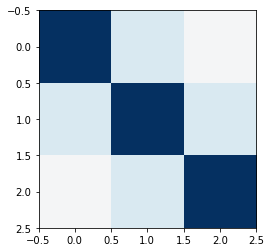

In [33]:
plt.imshow(cov_to_corr(cov['tot'][0]), cmap='RdBu', vmin=-1, vmax=1)

In [34]:
# fisher = np.zeros([npar, npar])
# # invcov_w = like_euclid_wl.invcovmat_l

# for (i1, par1), (i2, par2) in itertools.combinations_with_replacement(enumerate(params), 2):
#     for il, l in enumerate(ells):
#         fisher[i1, i2] += np.dot(np.dot(dcls_dpar[par1][ell], invcov_l[il]), dcls_dpar[par2][ell])

# fisher = fisher + fisher.T - np.diag(fisher.diagonal())

In [35]:
def get_fisher(params, cls_dpar_p, cls_dpar_m, invcov_l, cl_keys):
    print(cl_keys)
    dcls_dpar = {}
    for par in params:
        dcls_dpar[par] = {}
        for il, ell in enumerate(ells):
            dcls_dpar[par][ell] = np.zeros(len(cl_keys))
            for ik, key in enumerate(cl_keys):
                dcls_dpar[par][ell][ik] = (cls_dpar_p[par][key][ell] - cls_dpar_m[par][key][ell])/(delta_par[par])
    
    fisher = np.zeros([npar, npar])
    # invcov_w = like_euclid_wl.invcovmat_l
#     print(cl_keys)
    for (i1, par1), (i2, par2) in itertools.combinations_with_replacement(enumerate(params), 2):
        for il, l in enumerate(ells):
            fisher[i1, i2] += np.dot(np.dot(dcls_dpar[par1][ell], invcov_l[il]), dcls_dpar[par2][ell])  
    fisher = fisher + fisher.T - np.diag(fisher.diagonal())    
    return fisher, dcls_dpar

In [36]:
fish_tot, dcls_par_tot = get_fisher(params, cls_dpar_p, cls_dpar_m, invcov['tot'], cl_keys)
fish_adf, dcls_par_adf = get_fisher(params, cls_dpar_p, cls_dpar_m, invcov['adf'], cl_adf_keys)
fish_arf, dcls_par_arf = get_fisher(params, cls_dpar_p, cls_dpar_m, invcov['arf'], cl_arf_keys)

['W1xW1', 'W1xW2', 'W2xW2']
['W1xW1']
['W2xW2']


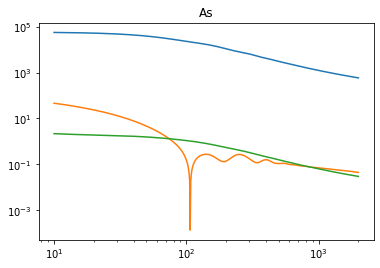

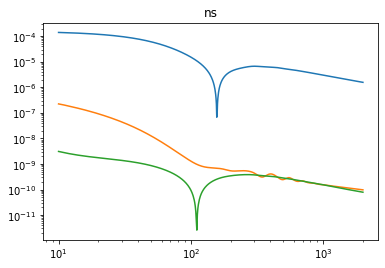

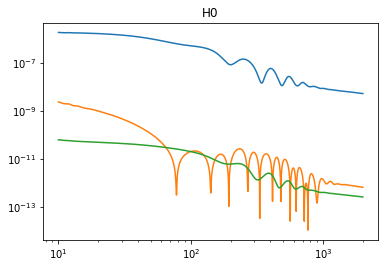

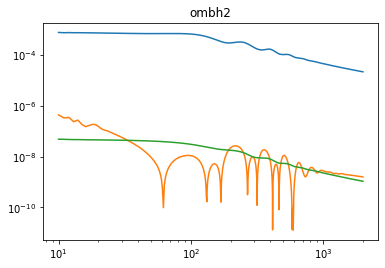

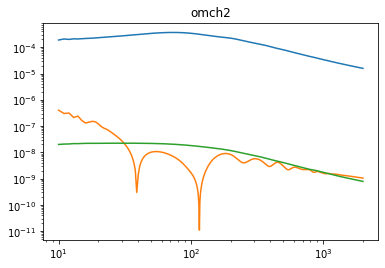

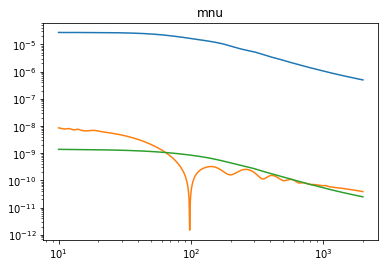

In [37]:
# plt.plot(ells, np.array([dcls_par_tot['As'][ell][0] for ell in ells]))
# plt.plot(ells, np.array([dcls_par_adf['As'][ell][0] for ell in ells]))
# plt.plot(ells, np.array([dcls_par_arf['As'][ell][0] for ell in ells]))


# param = 'As'
# param = 'ns'

for param in params:
    plt.figure()
    plt.title(param)
    for ik, key in enumerate(cl_keys):
        i1, i2 = key.split('x')
        if i2 == i2:
            plt.plot(ells, np.abs(np.array([dcls_par_tot[param][ell][ik] for ell in ells])), label=key)

    plt.loglog()
#     plt.legend()

In [38]:
np.linalg.inv(fish_arf)

array([[ 9.92211107e-05, -3.50065202e+04, -6.67563491e+06,
         5.64406586e+02,  3.03973230e+03,  1.17727016e+04],
       [-3.84065138e+04,  1.42225089e+13,  2.65935212e+15,
        -2.09985356e+11, -1.31509971e+12, -6.43672432e+12],
       [-6.96149122e+06,  2.51455490e+15,  5.61448754e+17,
        -4.31628795e+13, -2.57976440e+14, -9.61706170e+14],
       [ 1.28320530e+02, -3.40547703e+10, -1.21792057e+13,
        -2.73200582e+09, -2.09665563e+08,  3.17166816e+10],
       [ 2.82064673e+03, -1.11713201e+12, -2.34562481e+14,
         1.27747745e+10,  1.09466602e+11,  3.66503876e+11],
       [ 9.88392924e+03, -5.13105426e+12, -7.50599938e+14,
         9.16259690e+10,  3.20690891e+11, -5.86406201e+12]])

In [39]:
for ip, par in enumerate(params):
    if fish_tot[ip, ip] == 0:
        print("{} : 0 ".format(par))
    else:
#         print("{} : {} ".format(par, np.sqrt(1/fish[ip, ip]) / fiducials[par]))
        
#         print("{} : {} ".format(par, np.sqrt(np.linalg.inv(fisher)[ip, ip]) / fiducials[par])) 
#         print(np.linalg.inv(fisher)[ip, ip])
        print(f"{par} :")
        print("  tot {} ".format(np.sqrt(np.abs(np.linalg.inv(fish_tot)[ip, ip])) / fiducials[par]))  
    
        print("  adf {} ".format(np.sqrt(np.abs(np.linalg.inv(fish_adf)[ip, ip])) / fiducials[par]))                 
        
        print("  arf {} ".format(np.sqrt(np.abs(np.linalg.inv(fish_arf)[ip, ip])) / fiducials[par]))                     

As :
  tot 50065.12593377758 
  adf 27201.792976405653 
  arf 4699393.151393144 
ns :
  tot 7891.565541496837 
  adf 23756.231236434873 
  arf 3913388.0776118757 
H0 :
  tot 19174.60107694123 
  adf 53354.83819620849 
  arf 11180387.562718226 
ombh2 :
  tot 124939.83803041842 
  adf 78363.72658578667 
  arf 2358083.4134062263 
omch2 :
  tot 25335.491950191463 
  adf 34676.58347894584 
  arf 2750397.1478031473 
mnu :
  tot 901041.4388462628 
  adf 505746.66591522604 
  arf 24215825.43463124 


In [40]:
gauss_tot = GaussianND(mean, np.linalg.inv(fish_tot), names=params, labels=labels)
gauss_adf = GaussianND(mean, np.linalg.inv(fish_adf), names=params, labels=labels)
gauss_arf = GaussianND(mean, np.linalg.inv(fish_arf), names=params, labels=labels)
# Plots
# from getdist import plots
# from getdist.gaussian_mixtures import GaussianND

/Users/louis/Code/getdist/getdist/gaussian_mixtures.py:39: RuntimeWarning: invalid value encountered in sqrt
  self.norms = (2 * np.pi) ** (0.5 * self.dim) * np.array([np.sqrt(np.linalg.det(cov)) for cov in self.covs])


/Users/louis/Code/getdist/getdist/gaussian_mixtures.py:114: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(cov[i, i])
/Users/louis/Code/getdist/getdist/gaussian_mixtures.py:164: RuntimeWarning: invalid value encountered in sqrt
  res = np.exp(-dx ** 2 / var / 2) / np.sqrt(2 * np.pi * var)


ValueError: Axis limits cannot be NaN or Inf

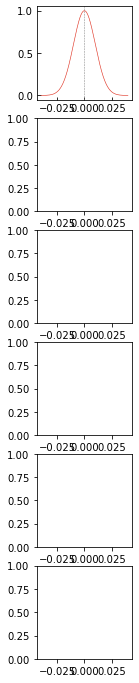

In [41]:
g = plots.get_subplot_plotter()

g.triangle_plot([gauss_adf, gauss_arf, gauss_tot],  filled=True, 
                markers=fiducials, 
                marker_args={'lw':2.})